# Inversion of individual Hanle profiles


### Here we will invert a couple of profiles that exhibit Hanle effect signatures. These are kindly provided by David Orozco Suarez. We will also look ast some of the maps observed by the same telescope later. 

In [36]:
import numpy as np 
import hazel 
import matplotlib.pyplot as plt 
import h5py
from astropy.io import fits 

In [37]:
# Let's first load a profile:
data = np.loadtxt("profiles/profA1.perf",skiprows=1,unpack=True)
data.shape

(9, 81)

In [38]:
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

Text(0.5, 0, 'Wavelength')

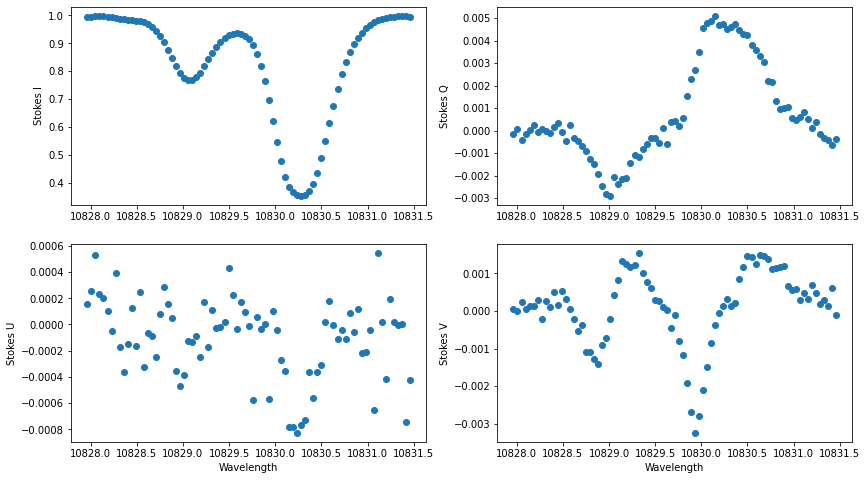

In [39]:
# Let's visualize these profiles: 
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

### We will go straight to the inversion, we know what we need to do! 

In [40]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt('10830_A1.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A1.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

# Note, the magical number we are multiplying stokes vector with will become clear soon!
stokes_to_fit = stokes * 0.89388

f = open('10830_A1_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'50.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()



In [58]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_A1.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-28 09:34:58,542 - Hazel2 v1.0
2022-01-28 09:34:58,543 - Using configuration from file : conf_test_A1.ini
2022-01-28 09:34:58,544 - Backtracking mode : brent
2022-01-28 09:34:58,545 - Adding spectral region spec1
2022-01-28 09:34:58,545 -   - Reading wavelength axis from 10830_A1.wavelength
2022-01-28 09:34:58,546 -   - Reading wavelength weights from 10830_A1.weights
2022-01-28 09:34:58,547 -   - Using observations from 10830_A1_stokes.1d
2022-01-28 09:34:58,547 -   - No mask for pixels
2022-01-28 09:34:58,547 -   - No instrumental profile
2022-01-28 09:34:58,548 -   - Using LOS ['50.0', '0.0', '90.0']
2022-01-28 09:34:58,548 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-01-28 09:34:58,548 - Using 3 cycles
2022-01-28 09:34:58,549 - Using analytical RFs if possible : False
2022-01-28 09:34:58,549 - Using 10 max. iterations
2022-01-28 09:34:58,549 - Not using randomizations
2022-01-28 09:34:58,549 - Stopping when relative error is below 1e-05
2022-01-28 09:34:5

In [59]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(1,4,n_wvl)
fit.shape


(1, 4, 81)

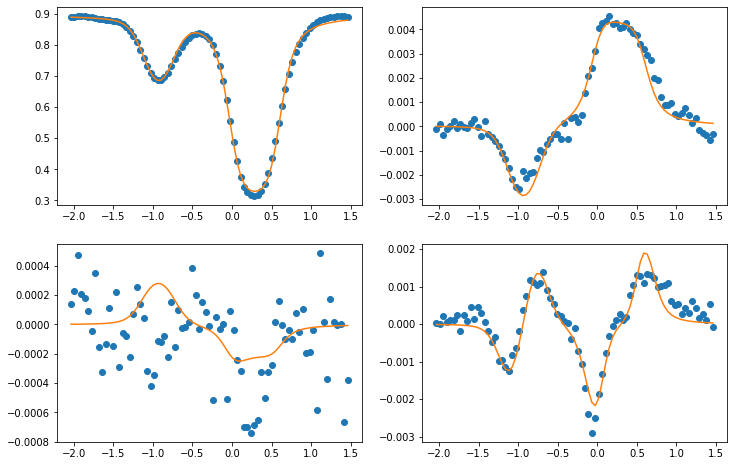

In [60]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
plt.plot(ll-10830,fit[0,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
plt.plot(ll-10830,fit[0,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
plt.plot(ll-10830,fit[0,2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
plt.plot(ll-10830,fit[0,3,:])

In [61]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("beta= ",result['ch1']['beta'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])
result.close()

Bx=  -25.25414753858945
By=  0.758583980963806
Bz=  -1.0163043212231173
tau=  3.3346184642016516
vlos  -0.5169926864993553
vtherm=  5.910046671189198
beta=  1.0
a=  0.2795158202148749


### How to interpret this? Let's look at the observing geometry one more time! 
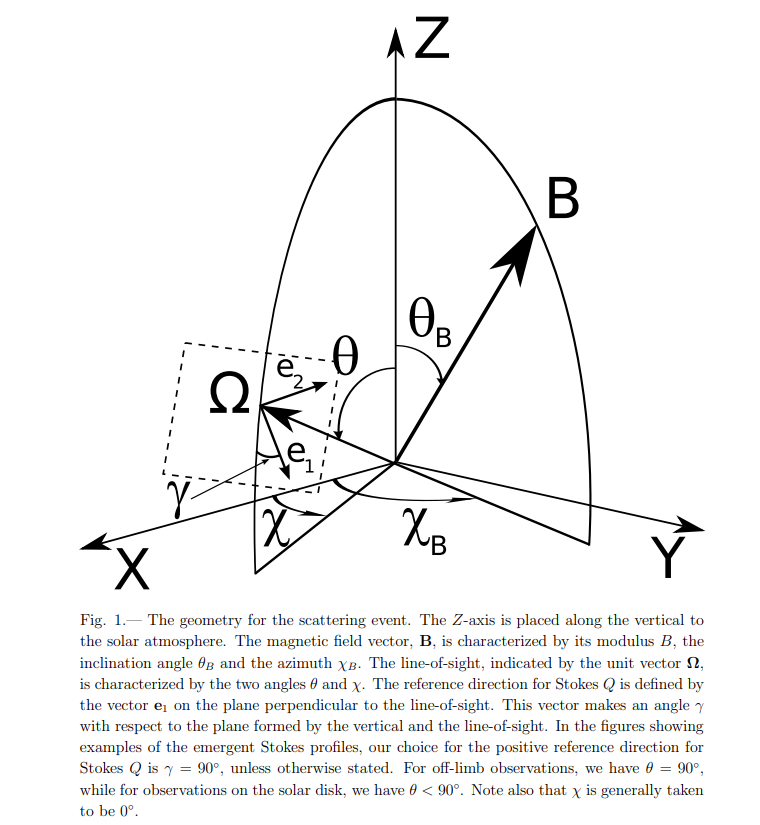

# Now we can try profile 6. This is a prominence, 22" above the limb!

In [62]:
data = np.loadtxt("profiles/profA6.perf",skiprows=1,unpack=True)
data.shape
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

Text(0.5, 0, 'Wavelength')

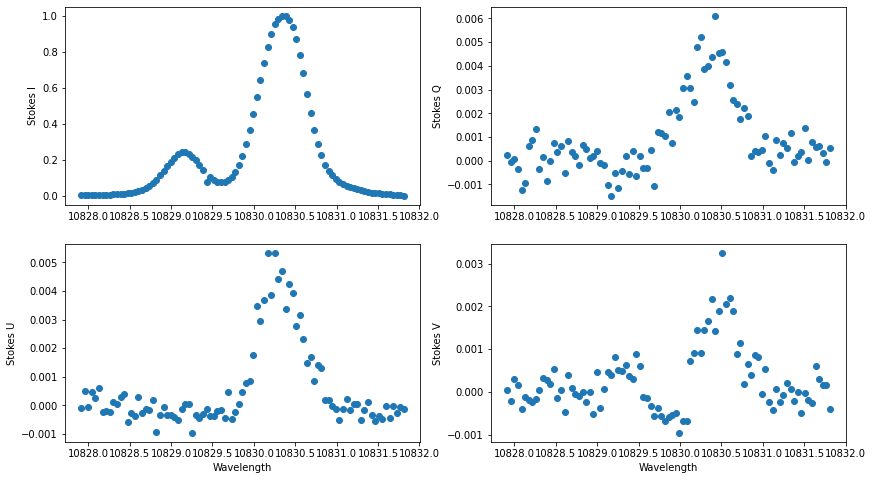

In [63]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

In [69]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt('10830_A6.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A6.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

stokes_to_fit = stokes

# And finally, the 'observed' Stokes parameters:

f = open('10830_A6_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()


In [122]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_A6.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-28 10:19:11,568 - Hazel2 v1.0
2022-01-28 10:19:11,569 - Using configuration from file : conf_test_A6.ini
2022-01-28 10:19:11,570 - Backtracking mode : brent
2022-01-28 10:19:11,571 - Adding spectral region spec1
2022-01-28 10:19:11,571 -   - Reading wavelength axis from 10830_A6.wavelength
2022-01-28 10:19:11,572 -   - Reading wavelength weights from 10830_A6.weights
2022-01-28 10:19:11,573 -   - Using observations from 10830_A6_stokes.1d
2022-01-28 10:19:11,574 -   - No mask for pixels
2022-01-28 10:19:11,574 -   - No instrumental profile
2022-01-28 10:19:11,574 -   - Using LOS ['90.0', '0.0', '90.0']
2022-01-28 10:19:11,575 -   - Using off-limb normalization (peak intensity)
2022-01-28 10:19:11,575 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2022-01-28 10:19:11,575 - Using 2 cycles
2022-01-28 10:19:11,575 - Using analytical RFs if possible : False
2022-01-28 10:19:11,576 - Using 20 max. iterations
2022-01-28 10:19:11,576 - Not using randomizations
2022-01-28 1

In [123]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(1,4,n_wvl)
fit.shape

(1, 4, 91)

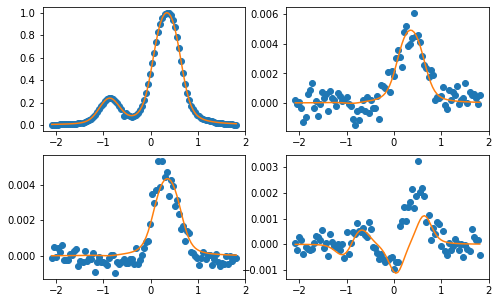

In [127]:
plt.figure(figsize=[8,5])
r = 0
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
plt.plot(ll-10830,fit[r,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
plt.plot(ll-10830,fit[r,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
plt.plot(ll-10830,fit[r,2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
plt.plot(ll-10830,fit[r,3,:])

In [125]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])
result.close()

Bx=  7.30818226224752
By=  3.48644437832899
Bz=  0.8906918603906675
tau=  1.4705093910628277
vlos  1.1270671675500168
vtherm=  7.033323014236417
a=  0.2635302897646019


## "And you're always going to come back to this picture...." How is the magnetic field looking like? 

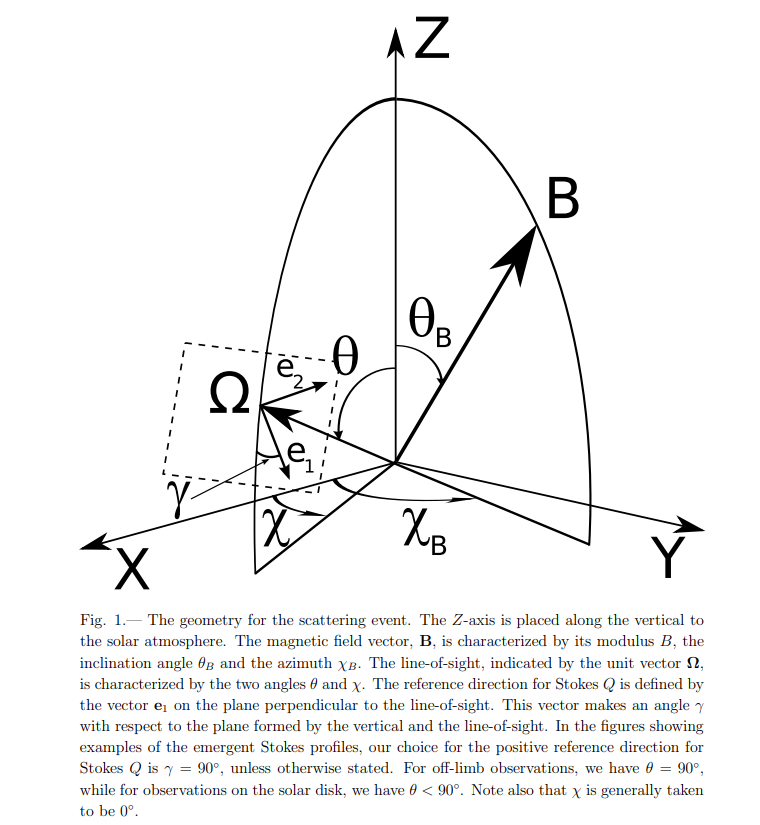